# 분류 성능 평가  
## 분류 성능 평가 지표  
정확도  
오차행렬  
정밀도  
f1스코어  
ROC AUC

### 정확도   
예측결과가 동일한 데이터 건수 / 전체 예측 데이터 건수  
이진분류에서는 여러개의 조건을 사용하지 않는 별거 아닌 알고리즘도 높은 정확도를 나타내는 상황이 발생할 수 있다.

In [363]:
#사이킷런의 BaseEstimator 클래스를 상속받아 아무런 학습을 하지 않고 성별에 따라 생존자를 예측하는 단순한 Classifier 생성
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    # fit()메서드는 아무것도 학습하지 않음
    def fit(self, X, y = None):
        pass
    #predict()메서드는 단순히 Sex피처가 1이면 0, 그렇지 않으면 1로 예측
    def predict(self, X):
        pred = np.zeros((X.shape[0], 1))
        for i in range(X.shape[0]):
            if X['Sex'].iloc[i] == 1:
                pred[i] = 0
            else:
                pred[i] = 1
        return pred

In [364]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace = True)
    df['Embarked'].fillna('N', inplace = True)
    df['Fare'].fillna(0, inplace = True)
    return df
#머신러닝 알고리즘에 불필요한 피처 제거
def drop_features(df):
    df.drop(['PassengerId','Name','Ticket'], axis = 1, inplace = True)
    return df
#래이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df
#앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [365]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
#원본 데이터를 재로딩, 데이터 가공, 학습 데이터.테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size=0.2, random_state=0)

#학습, 예측, 평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print('Dummy Classifier의 정확도는: {0:.4f}'.format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


In [366]:
#정확도는 불균형한(imbalanced)한 레이블 값 분포에서 ML모델 성능을 판단할 경우 적합한 평가 지표가 아님
#mnist데이터셋 예측

In [367]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass

    #입력값으로 들어오는 X데이터 세트의 크기만큼 모두 0값으로 만들어서 반환
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)

#사이킷런의 내장 데이터세트인 load_digits()을 이용해 MNIST데이터 로딩
digits = load_digits()

#digits번호가 7번이면 True이고 이를 astype(int)로 1로 변환, 7번이 아니면 False이고 0으로 변환
y = (digits.target == 7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y,  random_state = 11)

In [368]:
#불균형한 레이블 데이터 분포도 확인
print('레이블 테스트 세트 크기:', y_test.shape)
print('테스트 세트 레이블 0과 1의 분포도')
print(pd.Series(y_test).value_counts())

#Dummy Classifier로 학습/예측/정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print('모든 예측을 0으로 하여도 정확도는 {:.3f}'.format(accuracy_score(y_test, fakepred)))
#무려 0.9의 정확도가 나온다

레이블 테스트 세트 크기: (450,)
테스트 세트 레이블 0과 1의 분포도
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는 0.900


## 오차행렬
TN(true negative) : 예측값을 negative(0)으로 예측하고 실제 값 역시 negative(0)  
FP(false positive) : 예측값을 positive(1)으로 예측했으나 실제 값은 negative(0)  
FN(false negative) : 예측값을 negative(0)으로 예측했으나 실제 값은 positive(1)  
TP(true positive) : 예측값을 positive(1)으로 예측하고 실제 값 역시 positive(1)

In [369]:
#MyFakeClassifier의 예측 결과인 fakepred와 실제 결과인 y_test를 confusion_matrix()의 인자로 입력해 오차 행렬 출력
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)
#TN:array[0,0], FP:array[0,1], FN:array[1,0], TP:array[1,1]
#이 값들을 조합해 Classifier의 성능을 측정할 수 있는 요소인 정확도, 정밀도, 재현율을 알 수 있다

array([[405,   0],
       [ 45,   0]], dtype=int64)

### 정확도: 예측결과와 실제값이 동일한 건수 / 전체 데이터 수 = (TN+TP) / (TN+FP+FN+TP)  

### 정밀도: 예측을 Positive로 한 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율  
정밀도 = TP / (FP + TP)  
### 재현율: 실제값이 Positive인 대상 중 예측과 실제 값이 Positive로 일치한 데이터의 비율(민감도, TPR)  
재현율 = TP / (FN + TP)  
정밀도와 재현율 중 무엇이 중요한가는 업무 특성에 따라 달라질 수 있다  
재현율이 중요 지표: 실제 Positive데이터를 Negative로 판단하면 업무상 큰 영향이 발생(암 판단)  
정밀도가 중요 지표: 스팸메일분류(Negative를 Positive로 판단하면 메일을 받지 못해 피해 발생)  
재현율은 FN(실제Positive, 예측Negative)를 낮추는 데에, 정밀도는 FP(실제Negative, 예측Positive)를 낮추는 데에 초점  
정밀도와 재현율 모두 높을수록 좋다!  

In [370]:
#오차행렬, 정밀도, 재현율을 모두 구해 예측 성능 평가
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
def get_clf_eval(y_test, pred): #matrix, accuracy, precision, recall등의 평가를 한번에 호출하는 함수 만들기
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print('오차행렬')
    print(confusion)
    print(f'정확도:{accuracy:.4f}, 정밀도:{precision:.4f}, 재현율:{recall:.4f}')

In [371]:
#로지스틱 회귀 기반으로 생존자를 예측하고 confusion matrix, accuracy, precision, recall 평가 수행
#solver='liblinear'는 로지스틱회귀의 최적화 알고리즘 유형을 지정하는 것
#보통 작은 데이터셋의 이진 분류인 경우 solver='liblinear'가 성능이 좋은 경향이 있음(기본값:lbfgs->데이터가 크고 다중 분류인 경우 적합)
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
#원본 데이터를 재로딩, 데이터 가공, 학습 데이터/테스트 데이터 분할
titanic_df = pd.read_csv('titanic_train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis = 1)
X_titanic_df = transform_features(X_titanic_df)

X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, 
                                                    test_size = 0.2, random_state = 11)
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
get_clf_eval(y_test, pred)

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


### 정밀도/재현율 트레이드오프
분류하려는 업무의 특성상 정밀도 또는 재현율이 특별히 강조돼야 할 분류의 결정 임곗값(Threshold)를 조정해 정밀도 또는 재현율의 수치를 높일 수 있다  
하지만 정밀도와 재현율은 상호보완적 지표이기 때문에 어느 한쪽을 높이면 반대쪽은 떨어지기 쉽다  
이를 정밀도/재현율의 트레이드오프(trade-off)라고 부른다

사이킷런의 분류 알고리즘은 개별 레이블별로 결정 확률을 구한다  
그리고 예측 확률이 큰 레이블값으로 예측하게 된다  
가령 이진 분류 모델에서 특정 데이터가 0이 될 확률이 10%, 1이 될 확률이 90%로 예측됐다면  
최종 예측은 더 큰 확률을 가진 1로 예측된다  
일반적으로 이진 분류에서는 이 임곗값을 0.5로 정하고 이 기준 값보다 확률이 크면 positive, 작으면 negative로 결정한다

### 사이킷런은 개별 데이터별로 예측 확률을 반환하는 메서드인 predict_proba()를 제공한다  
predict_proba()는 학습이 완료된 사이킷런 Classifier에서 호출이 가능하며 테스트 피치 데이터셋을 파라미터로 입력해주면  
테스트 피처 레코드의 개별 클래스 예측 확률을 반환  
predict()와 유사하지만 반환결과가 예측 결과 클래스값이 아닌 예측 확률 결과이다  
입력 파라미터: predict()와 동일하게 보통 테스트 피처 데이터셋 입력  
반환값: 개별 클래스의 예측 확률을 ndarray m*n 형태로 반환(m:입력값의 레코드 수, n:클래스 값 유형)

In [372]:
#바로 앞 타이타닉 데이터를 학습은 logisticRegression객체에서 predict_proba()메서드를 수행한 뒤 반환값을 확인하고
#predict()메서드의 결과와 비교해보기
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print(f'pred_proba()결과 shape : {pred_proba.shape}')
print('pred_proba array에서 앞 3개만 샘플로 추출: \n:', pred_proba[:3])

#예측 확률 array와 예측 결괏값 array를 병합(concatenate)해 예측 확률과 결괏값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis = 1)
print('두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n', pred_proba_result[:3])
#반환 결과인 ndarray는 0과 1에 대한 확률을 나타낸다

pred_proba()결과 shape : (179, 2)
pred_proba array에서 앞 3개만 샘플로 추출: 
: [[0.44935227 0.55064773]
 [0.86335512 0.13664488]
 [0.86429645 0.13570355]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.44935227 0.55064773 1.        ]
 [0.86335512 0.13664488 0.        ]
 [0.86429645 0.13570355 0.        ]]


사이킷런은 분류 결정 임곗값을 조절해 정밀도와 재현율의 성능 수치를 상호 보완적으로 조정할 수 있다

Binarize 클래스

In [373]:
from sklearn.preprocessing import Binarizer
X = [[1,-1,2],
     [2,0,0],
     [0,1.1,1.2]]
# X의 개별 원소들이 threshold값보다 같거나 작으면 0을, 크면 1을 반환
binarizer = Binarizer(threshold = 1.1)
print(binarizer.fit_transform(X))
#X데이터세트에서 Binarizer의 threshold값이 1.1보다 작거나 같으면 0, 크면 1로 변환

[[0. 0. 1.]
 [1. 0. 0.]
 [0. 0. 1.]]


In [374]:
#predict 의사 코드 만들기
#예측 확률값인 pred_proba 객체 변수에 분류 결정 임곗값(threshold)를 0.5로 지정한 Binarizer 클래스를 적용해 최종 예측값 구하기
#이렇게 구한 최종 예측값에 get_clf_eval()함수를 적용해 평가 지표도 출력
from sklearn.preprocessing import Binarizer
#Binarize의 threshold 설정값. 즉 분류 결정 임곗값
custom_threshold = 0.5

#predict_proba()의 반환값의 두번째 칼럼, 즉 Positive 클래스 칼럼 하나만 추출해 Binarizer를 적용
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
#이 의사코드로 계산된 평가 지표는 앞 타이타닉 데이터로 학습된 로지스틱회귀 Classifier객체에서 호출된 predict()로 계산된 지표값과 일치

오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705


In [375]:
#임곗값을 0.4로 낮추면?
custom_threshold = 0.4
pred_proba_1 = pred_proba[:, 1].reshape(-1,1)
binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_1)
custom_predict = binarizer.transform(pred_proba_1)

get_clf_eval(y_test, custom_predict)
#임곗값을 낮추니 정밀도가 떨어지고 재현율이 올라갔다
#why?

오차행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197


분류 결정 임곗값은 Positive 예측값을 결정하는 확률의 기준이 된다  
확률이 0.5가 아닌 0.4부터 Positive로 예측을 더 너그럽게 하기 때문에 값을 낮출수록 True값이 더 많아지게 된다  
Positive값이 많아지면 양성 예측을 많이 하다보니 실제 양성을 음성으로 예측한 횟수(FN)이 적어진다->재현율 증가  
그러나 실제 음성을 양성으로 예측한 횟수(FP)는 증가하므로 정밀도는 떨어진다

In [376]:
#임곗값을 0.4부터 0.6까지 0.05씩 증가시키며 평가 지표 조사
thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]

def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    # thresholds list객체 내의 값을 차례로 iteration하면서 Evaluation 수행
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold = custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print('임곗값:', custom_threshold)
        get_clf_eval(y_test, custom_predict)
        
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값: 0.4
오차행렬
[[97 21]
 [11 50]]
정확도:0.8212, 정밀도:0.7042, 재현율:0.8197
임곗값: 0.45
오차행렬
[[105  13]
 [ 13  48]]
정확도:0.8547, 정밀도:0.7869, 재현율:0.7869
임곗값: 0.5
오차행렬
[[108  10]
 [ 14  47]]
정확도:0.8659, 정밀도:0.8246, 재현율:0.7705
임곗값: 0.55
오차행렬
[[111   7]
 [ 16  45]]
정확도:0.8715, 정밀도:0.8654, 재현율:0.7377
임곗값: 0.6
오차행렬
[[113   5]
 [ 17  44]]
정확도:0.8771, 정밀도:0.8980, 재현율:0.7213


precision_recall_curve(): 임곗값을 변경해가며 정밀도와 재현율 출력  
입력 파라미터  
  y_true: 실제 클래스값 배열(배열 크기=[데이터 건수])  
  probas_pred: Positive칼럼의 예측 확률 배열(배열 크기=[데이터 건수])  
반환값:  
  정밀도: 임곗값 별 정밀도 값을 배열로 반환  
  재현율: 임곗값 별 재현율 값을 배열로 반환

In [377]:
from sklearn.metrics import precision_recall_curve
#레이블 값이 1일 때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:, 1]

#실제값 데이터 세트와 레이블 값이 1일 때의 예측 확률을 precision_recall_curve 인자로 입력
precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_class1)
print('반환된 분류 결정 임곗값 배열의 shape:', thresholds.shape)

#반환된 임게값 배열 로우가 147건이므로 샘플로 10건만 추출하되 임곗값을 15 step으로 추출
thr_index = np.arange(0, thresholds.shape[0], 15)
print('샘플 추출을 위한 임계값 배열의 index 10개:', thr_index)
print('샘플용 10개의 임곗값:', np.round(thresholds[thr_index], 2))

#15 step 단위로 추출된 임계값에 따른 정밀도와 재현율 값
print('샘플 임계값별 정밀도:', np.round(precisions[thr_index], 3))
print('샘플 임계값별 재현율:', np.round(recalls[thr_index], 3))
#버전이 달라 책과 다른 결과가 출력됨

반환된 분류 결정 임곗값 배열의 shape: (165,)
샘플 추출을 위한 임계값 배열의 index 10개: [  0  15  30  45  60  75  90 105 120 135 150]
샘플용 10개의 임곗값: [0.02 0.11 0.13 0.14 0.16 0.24 0.32 0.45 0.62 0.73 0.87]
샘플 임계값별 정밀도: [0.341 0.372 0.401 0.44  0.505 0.598 0.688 0.774 0.915 0.968 0.938]
샘플 임계값별 재현율: [1.    1.    0.967 0.902 0.902 0.902 0.869 0.787 0.705 0.492 0.246]


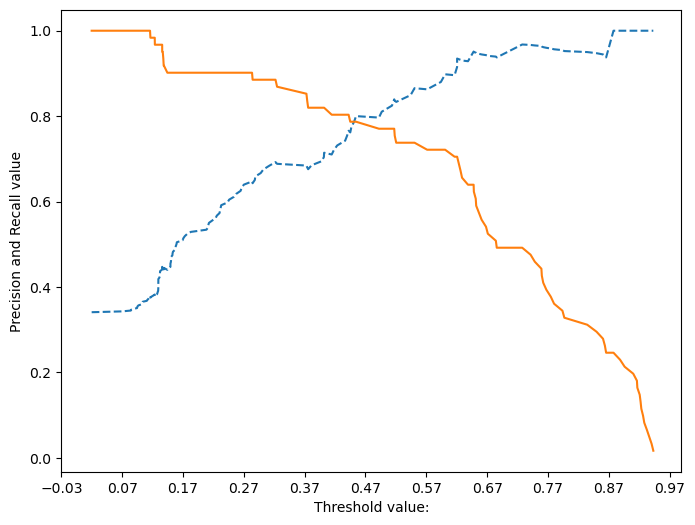

In [378]:
#precision_recall_curve() API는 정밀도와 재현율의 임곗값에 따른 값 변화를 곡선 형태의 그래프로 시각화하는데 이용할 수 있다
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline
def precision_recall_curve_plot(y_test, pred_proba_c1):
    #threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)

    #x축을 threshold값으로, y축은 정밀도, 재현율 값으로 각각 Plot수행, 정밀도는 점선으로 표시
    plt.figure(figsize = (8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    #threshold값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))

    #x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value:')
    plt.ylabel('Precision and Recall value')
    plt.show()

precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:, 1])
#임곗값이 낮을수록 많은 양성 예측으로 인해 재현율이 극도로 높아지고 정밀도 값이 극도로 낮아짐
#임곗값을 증가시킬수록 반대의 양상이 된다

### 정밀도와 재현율의 맹점  
정밀도와 재현율 두 수치를 상호 보완할 수 있는 수준에서 임곗값 변경이 적용되어야 한다  
정밀도 또는 재현율 하나만 스코어가 좋고 다른 하나는 나쁜 분류는 성능이 좋지 못한 분류로 간주된다

## F1 스코어
F1 스코어는 정밀도와 재현율을 결합한 지표  
F1 스코어는 두 값이 어느 한 쪽으로 치우치지 않는 수치를 나타낼 대 상대적으로 높은 값을 가지게 된다  
F1 = 2 / (1 / recall) + (1 / precision) = 2 * ( (precision * recall) / (precision + recall) )  
만약 A예측모델이 정밀도 0.9, 재현율 0.1 이고 B예측모델은 정밀도 0.5, 재현율 0.5이면  
A모델의 F1 score는 0.18, B모델의 F1 score는 0.5로 B모델이 A모델에 비해 매우 우수한 F1스코어를 가지게 됨  

In [379]:
#사이킷런은 F1 스코어를 구하기 위해 f1_score()라는 API를 제공
#앞서 학습한 로지스틱 회귀 기반 타이타닉 생존자 모델의 F1 score를 구해보기
from sklearn.metrics import f1_score
f1 = f1_score(y_test, pred)
print(f'F1 스코어: {f1:.4f}')

F1 스코어: 0.7966


In [380]:
#타이타닉 생존자 예측에서 임곗값을 변화시키면서 F1 스코어를 포함한 평가 지표 구하기
#앞서 작성한 get_clf_eval()함수에 f1 스코어를 구하는 로직 추가
#get_eval_by_trheshold()함수를 이용해 0.4~0.6별로 정확도, 정밀도, 재현율, F1 스코어 알아보기
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)

    #F1 스코어 추가
    f1 = f1_score(y_test, pred)
    print('오차 행렬')
    print(confusion)
    # f1 score print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}\n')

thresholds = [0.4, 0.45, 0.50, 0.55, 0.60]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)
#임곗값 0.6일때 F1 스코어가 가장 높다
#그러나 재현율이 크게 감소하고 있으니 주의

임곗값: 0.4
오차 행렬
[[97 21]
 [11 50]]
정확도: 0.8212, 정밀도: 0.7042, 재현율: 0.8197, F1: 0.7576

임곗값: 0.45
오차 행렬
[[105  13]
 [ 13  48]]
정확도: 0.8547, 정밀도: 0.7869, 재현율: 0.7869, F1: 0.7869

임곗값: 0.5
오차 행렬
[[108  10]
 [ 14  47]]
정확도: 0.8659, 정밀도: 0.8246, 재현율: 0.7705, F1: 0.7966

임곗값: 0.55
오차 행렬
[[111   7]
 [ 16  45]]
정확도: 0.8715, 정밀도: 0.8654, 재현율: 0.7377, F1: 0.7965

임곗값: 0.6
오차 행렬
[[113   5]
 [ 17  44]]
정확도: 0.8771, 정밀도: 0.8980, 재현율: 0.7213, F1: 0.8000



## ROC곡선과 AUC  
ROC곡선: 수신자 판단 곡선  
FPR(False Positive Rate)가 변할 때 TPR(True Postive Rate)가 어떻게 변하는지 나타내는 곡선  
FPR을 x축, TPR을 y축으로 잡음  
TPR은 재현율(민감도)를 나타냄. 실제값 Positive가 정확히 예측돼야 하는 수준  
TPR = TP / (TP + FN)  
TNR(True Neagtive Rate): 특이성. 실제값 Negative가 정확이 예측돼야 하는 수준  
TNR = TN / (TN + FP)  
FPR = FP / (TN + FP) == 1 - TNR

ROC곡선이 가운데 곡선(동전을 무작위 던져 앞/뒤를 맞추는 랜덤수준 이진분류의 ROC곡선)에 가까울 수록 성능 떨어짐  
ROC곡선은 FPR을 0부터 1까지 바꿔가며 TPR의 변화값을 구한다  
분류 결정 임곗값을 변화시켜 FPR을 변화시킨다  
분류 결정 임곗값은 Positive예측값을 결정하는 확률의 기준이므로 FPR을 0으로 만드려면 임곗값을 1로 지정  
임곗값을 1로 만들면 데이터를 Positve로 예측할 수 없어 FP값이 0이 되므로 FPR은 0이 된다   
FPR을 1로 만드려면 임곗값을 0으로 지정하면 된다  
임곗값을 0으로 만들면 Negative예측이 없어 TN이 0이 되고 FPR값은 1이 된다

roc_curve() API  
입력 파라미터:  
y_true: 실제 클래스 값 array  
y_score: predict_proba()의 반환 값 array에서 Positive칼럼의 예측 확률이 보통 사용됨  
반환값:  
fpr: fpr값을 array로 반환  
tpr: tpr값을 array로 반환  
thresholds: threshold 값 array

In [381]:
#타이타닉 생존자 예측 모델의 FPR, TPR, 임곗값 구하기
from sklearn.metrics import roc_curve

#레이블 값이 1일때의 예측 확률을 추출
pred_proba_class1 = lr_clf.predict_proba(X_test)[:,1]

fprs, tprs, thresholds = roc_curve(y_test, pred_proba_class1)
#반환된 임곗값 배열에서 샘플로 데이터를 추출하되, 임곗값을 5 step으로 추출
#thresholds[0]은 max(예측확률)+1로 임의 설정됨. 이를 제외하기 위해 np.arange는 1부터 시작
thr_index = np.arange(1, thresholds.shape[0], 5)
print('샘플 추출을 위한 임곗값 배열의 index:', thr_index)
print('샘플 index로 추출한 임곗값:', np.round(thresholds[thr_index], 2))

# 5 step 단위로 추출된 임곗값에 따른 FPR, TPR 값
print('샘플 임곗값별 FPR:', np.round(fprs[thr_index], 3))
print('샘플 임곗값별 TPR:', np.round(tprs[thr_index], 3))

샘플 추출을 위한 임곗값 배열의 index: [ 1  6 11 16 21 26 31 36 41 46]
샘플 index로 추출한 임곗값: [0.94 0.73 0.62 0.52 0.44 0.28 0.15 0.14 0.13 0.12]
샘플 임곗값별 FPR: [0.    0.008 0.025 0.076 0.127 0.254 0.576 0.61  0.746 0.847]
샘플 임곗값별 TPR: [0.016 0.492 0.705 0.738 0.803 0.885 0.902 0.951 0.967 1.   ]


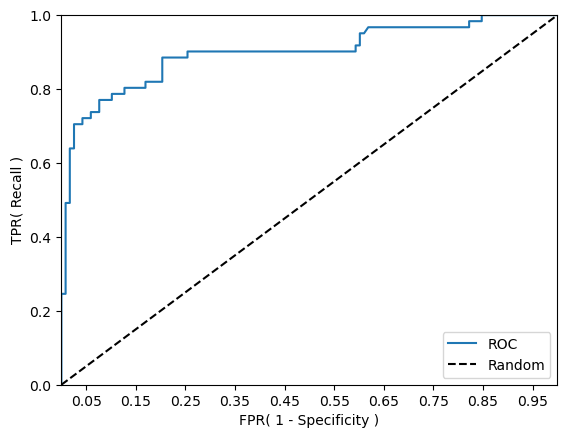

In [382]:
#시각화
def roc_curve_plot(y_test, pred_proba_c1):
    #임곗값에 따른 FPR, TPR값을 반환받음
    fprs, tprs, thresholds = roc_curve(y_test, pred_proba_c1)
    #ROC곡선을 그래프 곡선으로 그림
    plt.plot(fprs, tprs, label = 'ROC')
    #가운데 대각선 직선을 그림
    plt.plot([0,1],[0,1], 'k--', label='Random')

    #FPR X축의 scale을 0.1단위로 변경. X,Y축 명 설정 등
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Specificity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()

roc_curve_plot(y_test, pred_proba[:, 1])

일반적으로 ROC곡선은 FPR과 TPR 변화 값을 보는 데에 이용되며  
분류의 성능 지표로 사용되는 것은 ROC곡선 면적에 기반한 AUC값으로 결정  
AUC(Area Under Curve)값은 ROC곡선 밑의 면적을 구한 것으로 일반적으로 1에 가까울수록 좋은 수치  
AUC수치가 커지려면 FPR이 작은 상태에서 얼마나 큰 TPR을 얻을 수 있느냐가 관건

In [383]:
from sklearn.metrics import roc_auc_score
pred_proba = lr_clf.predict_proba(X_test)[:, 1]
roc_score = roc_auc_score(y_test, pred_proba)
print(f'ROC AUC 값: {roc_score:.4f}')

ROC AUC 값: 0.8987


In [384]:
#get_clf_eval()함수에 ROC AUC값 측정 로직 추가
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    #ROC AUC 스코어 추가
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print(f'정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {roc_auc:.4f}')

# 피마 인디언 당뇨병 예측
## 피마 인디언 당뇨병 데이터셋 피처
Pregnancies: 임신 횟수  
Glucose: 포도당 부하 검사 수치  
BloodPressure: 혈압(mm hg)  
SkinThickness: 팔 삼두근 뒤쪽의 피하지방 측정값(mm)  
Insulin: 혈청 인슐린(mu U/ml)  
BMI: 체질량지수((체중 / 키) ** 2)  
DiabetesPedigreeFunction: 당뇨 내력 가중치 값  
Age: 나이  
Outcome: 클래스 결정 값(0 또는 1)

In [444]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

diabetes_data = pd.read_csv('diabetes.csv')
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [445]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [446]:
#피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
#맨 끝이 Outcome 칼럼으로 레이블 값임. 칼럼 위치 -1을 이용해 추출
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 156, stratify = y)

#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression(solver = 'liblinear')
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[87 13]
 [22 32]]
정확도: 0.7727, 정밀도: 0.7111, 재현율: 0.5926, F1: 0.6465, AUC: 0.8083


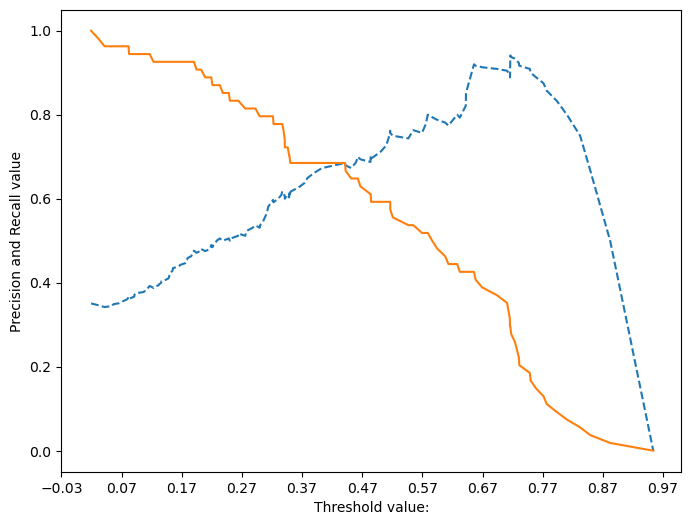

In [447]:
#임곗값 별 정밀도와 재현율 값의 변화 확인
pred_proba_c1 = lr_clf.predict_proba(X_test)[:, 1]
precision_recall_curve_plot(y_test, pred_proba_c1)
#임곗값 약 0.42에서 두 수치가 어느정도 균형이 맞긴 하나 두 수치 모두 너무 낮은 수치

In [448]:
#데이터 값 점검
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


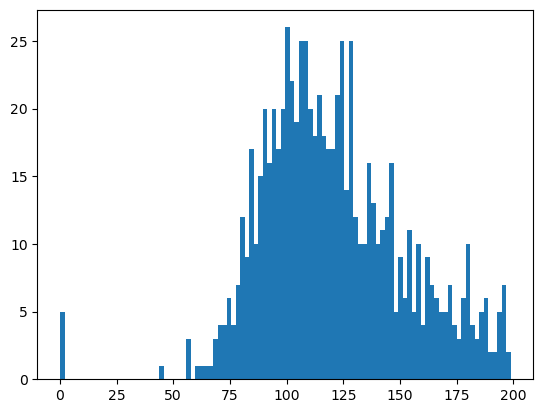

In [449]:
plt.hist(diabetes_data['Glucose'], bins = 100)
plt.show()
#Glucose(혈중 포도당 수치)가 0인 데이터가 존재

In [450]:
#min()이 0으로 돼 있는 피처에 대해 0값이 몇 퍼센트를 차지하고 있는지 확인

#0값을 검사할 피처명 리스트
zero_features = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

#전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

#피처별로 반복하면서 데이터 값이 0인 데이터 건수를 추출하고 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature] == 0][feature].count()
    print(f'{feature} 0 건수는 {zero_count}, 퍼센트는 {100*zero_count/total_count:.2f} %')

Glucose 0 건수는 5, 퍼센트는 0.65 %
BloodPressure 0 건수는 35, 퍼센트는 4.56 %
SkinThickness 0 건수는 227, 퍼센트는 29.56 %
Insulin 0 건수는 374, 퍼센트는 48.70 %
BMI 0 건수는 11, 퍼센트는 1.43 %


In [451]:
#이들 0 값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [452]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,121.681605,72.254807,26.606479,118.660163,32.450805,0.471876,33.240885,0.348958
std,3.369578,30.436016,12.115932,9.631241,93.080358,6.875374,0.331329,11.760232,0.476951
min,0.000000,44.000000,24.000000,7.000000,14.000000,18.200000,0.078000,21.000000,0.000000
25%,1.000000,99.750000,64.000000,20.536458,79.799479,27.500000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,79.799479,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [453]:
#0값을 평균값으로 대체한 데이터세트에 피처스케일링을 적용해 변환
#로지스틱 회귀의 경우 일반적으로 숫자 데이터에 스케일링을 적용하는 것이 좋다
X = diabetes_data.iloc[:, :-1]
y = diabetes_data.iloc[:, -1]

#StandardScaler 클래스를 이용해 피처 데이터 세트에 일괄적으로 스케일링 적용
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = 0.2, random_state = 156, stratify = y)

#로지스틱 회귀로 학습, 예측 및 평가 수행
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:, 1]

get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


In [454]:
#어느정도 향상됐으나 여전히 재현율 수치가 낮음
#분류 결정 임곗값을 변화시키며 어느정도 개선되는지 확인
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:, 1].reshape(-1,1), thresholds)

임곗값: 0.3


InvalidParameterError: The 'y_score' parameter of roc_auc_score must be an array-like. Got None instead.

In [455]:
#임곗값으 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold = 0.48)
#위에서 구한 lr_clf의 predict_proba() 예측 확률 array에서 1에 해당하는 칼럼값을 Binarizer 변환
pred_th_048 = binarizer.fit_transform(pred_proba[:, 1].reshape(-1,1))

get_clf_eval(y_test, pred_th_048, pred_proba[:, 1])

오차 행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
